In [1]:
import numpy as np
import scipy.io
import pandas as pd
import json
from typing import List, Callable
import run_classifiers
import matplotlib.pyplot as plt

corrs_location = '../corrs'
A_mats_location = '../A_mats'

participants = pd.read_table('../SRPBS_OPEN/participants.tsv')
participants = participants.dropna()

train_sites = ['COI','KUT','SWA','UTO']
test_sites = ['ATT','ATV','CIN','HKH','HRC','HUH','KTT']

In [2]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

def extract_participants_id(participants: pd.DataFrame, id: int) -> pd.DataFrame:
	return participants[[participant_id_to_number(name) == id for name in participants.participant_id.to_numpy()]]

def unpair(pairs: List[List[int]]) -> List[int]:
	return [id for pair in pairs for id in pair]

* 2 types of data (A matrices or correlations)
* 2 outlier choices (remove or not)
* 3 dataset subsets (all data, all pairs, perfect pairs)

In total - we have 2x2x3 = 12 datasets to feed into the classifiers

In [3]:
with open('../Dataset Analysis/dataset_all.txt','r') as f:
	ids_all_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/dataset_inliers.txt','r') as f:
	ids_inliers_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_pairs.txt','r') as f:
	ids_all_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_pairs.txt','r') as f:
	ids_inliers_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_perfect_pairs.txt','r') as f:
	ids_all_perfectpairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_perfect_pairs.txt','r') as f:
	ids_inliers_perfectpairs = np.array(json.loads(f.read()))

dataset_types = {
	'all': ids_all_all, 
	# 'inliers': ids_inliers_all, 
	# 'all_pairs': ids_all_pairs,
	# 'inliers_pairs': ids_inliers_pairs, 
	# 'all_perfectpairs': ids_all_perfectpairs, 
	# 'inliers_perfectpairs': ids_inliers_perfectpairs
}

In [4]:
def read_correlation(subject: int) -> np.ndarray:
	return np.nan_to_num(scipy.io.loadmat(f'{corrs_location}/correlation_components_{subject:04d}.mat')['corr_components'].reshape(1,-1))

def read_A_matrix(subject: int) -> np.ndarray:
	return scipy.io.loadmat(f'{A_mats_location}/dcm_A_{subject:04d}.mat')['A'].reshape(1,-1)

load_data_functions = {'corr': read_correlation, 'Amat': read_A_matrix}

In [5]:
def load_dataset(ids: np.ndarray, load_data_function: Callable[[int], np.ndarray]):
	if ids.ndim == 1: # single list of participants
		particpant_data = [extract_participants_id(participants, id) for id in ids]
	else: # pairs of participants
		particpant_data = [extract_participants_id(participants, id) for pair in ids for id in pair]
		ids = ids.flatten()
	particpants_train = [participant.site.to_numpy() in train_sites for participant in particpant_data]
	particpants_test = [participant.site.to_numpy() in test_sites for participant in particpant_data]

	X_train = np.vstack([load_data_function(id) for id in ids[particpants_train]])
	X_test = np.vstack([load_data_function(id) for id in ids[particpants_test]])
	labels = np.array(list(map(lambda participant: int(participant.diag // 2), particpant_data)))
	Y_train = labels[particpants_train]
	Y_test = labels[particpants_test]
	return X_train, X_test, Y_train, Y_test

In [6]:
datasets = []

for dataset_name, ids in dataset_types.items():
	for function_name, load_data_function in load_data_functions.items():
		datasets.append([f'{dataset_name}_{function_name}', *load_dataset(ids, load_data_function)])

In [7]:
for dataset in datasets:
	train_proportion = 100*dataset[3].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	test_proportion = 100*dataset[4].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	print(f'{dataset[0]}: (total - {dataset[3].shape[0] + dataset[4].shape[0]})\n\ttrain - [X: {dataset[1].shape}, Y: {dataset[3].shape}] ({train_proportion:.1f}%)\n\ttest -  [X: {dataset[2].shape}, Y: {dataset[4].shape}] ({test_proportion:.1f}%)')
for dataset_name, ids in dataset_types.items():
	print(f'{dataset_name} has {ids.size} participants')

all_corr: (total - 1043)
	train - [X: (626, 70876), Y: (626,)] (60.0%)
	test -  [X: (417, 70876), Y: (417,)] (40.0%)
all_Amat: (total - 1043)
	train - [X: (626, 142129), Y: (626,)] (60.0%)
	test -  [X: (417, 142129), Y: (417,)] (40.0%)
all has 1043 participants


In [9]:
import importlib
importlib.reload(run_classifiers)
scores = run_classifiers.run_classifiers([datasets[0]])

Processing dataset all_corr
... with Lasso_cv classifier
X_CV [(563, 70876)], y_CV [(563,)]
alpha validation scores = [0.7138192267502612, 0.7405085336119819], best alpha = 1.0
alpha validation scores = [0.6908307210031349, 0.6984500174155347], best alpha = 1.0
alpha validation scores = [0.7099442702890979, 0.713775687913619], best alpha = 1.0
alpha validation scores = [0.7291013584117033, 0.7290578195750609], best alpha = 0.5
alpha validation scores = [0.7100748867990246, 0.7291448972483456], best alpha = 1.0
alpha validation scores = [0.7557035876001392, 0.751828631138976], best alpha = 0.5
alpha validation scores = [0.732584465343086, 0.7517415534656914], best alpha = 1.0
alpha validation scores = [0.7290578195750609, 0.7365900383141764], best alpha = 1.0
alpha validation scores = [0.7174764890282131, 0.7174329501915708], best alpha = 0.5
alpha validation scores = [0.7216126785092302, 0.6947492163009404], best alpha = 0.5
X_CV [(563, 70876)], y_CV [(563,)]
alpha validation scores = 

In [ ]:
scores_df = pd.DataFrame(scores)
scores_df

C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027067344843733188, tolerance: 0.005874893617021278
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027399021299024974, tolerance: 0.0058740425531914895
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027087595607871273, tolerance: 0.005898305084745764
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028599394360160287, tolerance: 0.005899576271186441
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02696685237621695, tolerance: 0.0059
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02597725939684465, tolerance: 0.005896186440677966
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029648338490616412, tolerance: 0.005899576271186441
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027936914855018858, tolerance: 0.005898305084745764
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028707252063197904, tolerance: 0.005898305084745764
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027867898389376408, tolerance: 0.005893220338983051
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023015278200862035, tolerance: 0.005874893617021278
  model = cd_fast.enet_coordinate_descent(


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021713880778084053, tolerance: 0.0058740425531914895
  model = cd_fast.enet_coordinate_descent(


In [1]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index')

NameError: name 'scores_df' is not defined

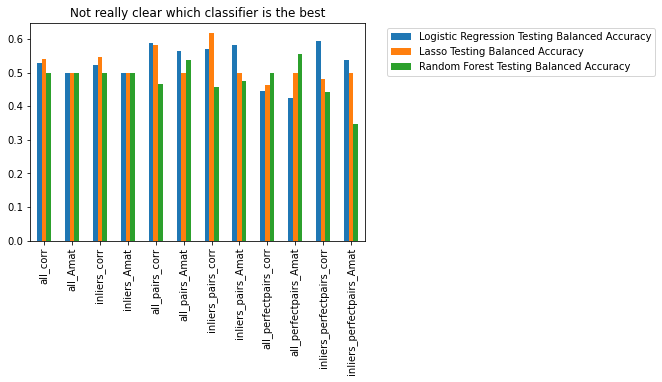

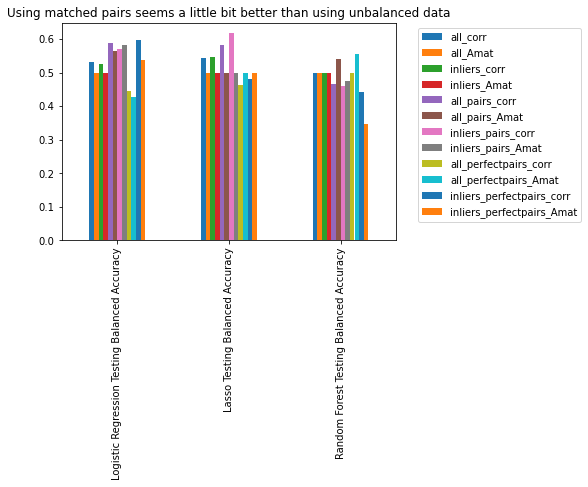

In [ ]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index').T.plot(kind='bar')
plt.title('Not really clear which classifier is the best')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

scores_df.filter(regex='.*Testing Balanced.*', axis='index').plot(kind='bar')
plt.title('Using matched pairs seems a little bit better than using unbalanced data')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

In [ ]:
np.save('classifier_scores', scores)